## Import library

In [1]:
from __future__ import print_function
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/kaggle/input/vgg/pytorch/default/1')
from vgg import vgg

## 設定超參數

In [3]:
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
EPOCHS = 60
LEARNING_RATE = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
LOG_INTERVAL = 100
CUDA = True
SEED = 1

RESUME = True
START_EPOCH = 0


# PRUNE_PATH = '/kaggle/input/vgg_prune/pytorch/ratio_pointnine/1/model_prune_ratio_0.9.pth'
PRUNE_PATH = '/kaggle/input/vgg_prune/pytorch/ratio_pointfive/1/model_prune_ratio_0.5.pth'
PRUNE_FINETUNE_PATH = f'/kaggle/working/model_prune_finetune.pth'


#### 檢查是否檢查是否可使用GPU

In [4]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}


## 下載資料集


這裡將訓練集做Augmentation(Pad, RandCrop, Random)，測試集不用做Augmentation

In [5]:
#### DATASET ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

100%|██████████| 170M/170M [00:02<00:00, 59.5MB/s]


## 載入剪枝後的網路與權重

In [6]:
model = None
if(RESUME):
  checkpoint = torch.load(PRUNE_PATH)
  model = vgg(cfg=checkpoint['cfg'])
  model.load_state_dict(checkpoint['state_dict'])

  print('RESUME PRUNE MODEL')

if CUDA:
    model.cuda()

RESUME PRUNE MODEL


## 設定Optimizer，這裡使用Stocastic Gradient Descent with

In [7]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

## 定義訓練跟測試函數

In [8]:
#### 訓練函數 #####
# 訓練時的準確率紀錄
train_accuracies = []

def train(epoch):
    model.train()
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        total += target.size(0)

        if batch_idx % LOG_INTERVAL == 0:
            print('\nTrain Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

    # 紀錄當前˙epoch 的訓練準確率
    train_accuracy = 100. * correct / total
    train_accuracies.append(train_accuracy)
    print('Train Epoch: {}  Accuracy: {}/{} ({:.1f}%)'.format(
        epoch+1, correct, total, train_accuracy))

In [9]:
#### 測試函數 ####
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      for data, target in test_loader:
          if CUDA:
              data, target = data.cuda(), target.cuda()
          data, target = Variable(data), Variable(target)
          output = model(data)
          test_loss += F.cross_entropy(output, target, reduction='sum').data.item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()

      test_loss /= len(test_loader.dataset)
      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      return correct / float(len(test_loader.dataset))

In [10]:
best_prec1 = 0.
for epoch in range(START_EPOCH, EPOCHS):
    # Learning Rate在0.5EPOCHS與0.75EPOCHS調整為原本之十分之一
    if epoch in [EPOCHS*0.5, EPOCHS*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train(epoch)
    prec1 = test()

    # 儲存模型權重，方便做後續剪枝,後續訓練
    if(prec1 > best_prec1):
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
        }, PRUNE_FINETUNE_PATH)

    best_prec1 = max(prec1, best_prec1)

print('\n TRAIN PRUNED MODEL DONE!')


Train Epoch: 1 [0/50000 (0.0%)]	Loss: 0.043479

Train Epoch: 1 [10000/50000 (20.0%)]	Loss: 0.455741

Train Epoch: 1 [20000/50000 (40.0%)]	Loss: 0.251627

Train Epoch: 1 [30000/50000 (60.0%)]	Loss: 0.308428

Train Epoch: 1 [40000/50000 (80.0%)]	Loss: 0.459929
Train Epoch: 1  Accuracy: 44592/50000 (89.2%)

Test set: Average loss: 0.4574, Accuracy: 8634/10000 (86.3%)


Train Epoch: 2 [0/50000 (0.0%)]	Loss: 0.276008

Train Epoch: 2 [10000/50000 (20.0%)]	Loss: 0.284852

Train Epoch: 2 [20000/50000 (40.0%)]	Loss: 0.357062

Train Epoch: 2 [30000/50000 (60.0%)]	Loss: 0.292905

Train Epoch: 2 [40000/50000 (80.0%)]	Loss: 0.173031
Train Epoch: 2  Accuracy: 45470/50000 (90.9%)

Test set: Average loss: 0.4603, Accuracy: 8589/10000 (85.9%)


Train Epoch: 3 [0/50000 (0.0%)]	Loss: 0.205487

Train Epoch: 3 [10000/50000 (20.0%)]	Loss: 0.245672

Train Epoch: 3 [20000/50000 (40.0%)]	Loss: 0.190022

Train Epoch: 3 [30000/50000 (60.0%)]	Loss: 0.363301

Train Epoch: 3 [40000/50000 (80.0%)]	Loss: 0.175634
Tr

## 繪製Fine-tuning結果圖


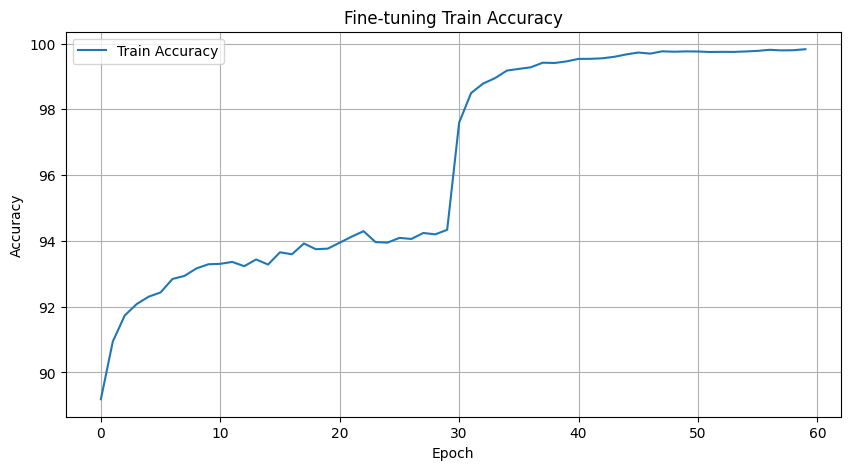

In [11]:
#繪製Fine-tuning結果圖
plt.figure(figsize=(10, 5))
plt.plot(range(START_EPOCH, EPOCHS), train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Fine-tuning Train Accuracy')
plt.legend()
plt.grid(True)
plt.show()